#  **Import Necessary Libraries**

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

# **Load the Dataset**

In [38]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)

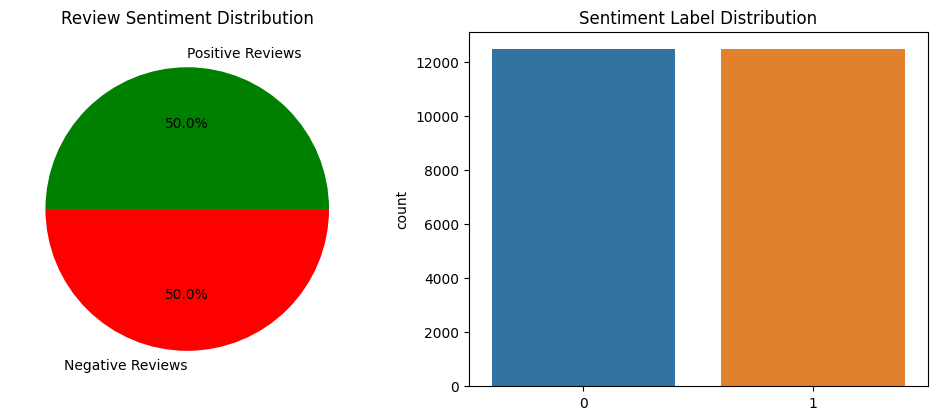

In [61]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
positive_count = np.sum(y_train == 1)
negative_count = np.sum(y_train == 0)
plt.pie([positive_count, negative_count], 
        labels=['Positive Reviews', 'Negative Reviews'], 
        autopct='%1.1f%%',
        colors=['green', 'red'])
plt.title('Review Sentiment Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x=y_train)
plt.title('Sentiment Label Distribution')

plt.tight_layout()
plt.show()

# **pad_sequences**

In [6]:
max_len=100
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# **Building Model**

In [8]:
def build_model(hyperparam):
    model = Sequential()
    
    model.add(Embedding(input_dim=10000, 
              output_dim=hyperparam.Int("embedding_output", min_value=64, max_value=300, step=32), 
              input_length=max_len, embeddings_regularizer=l2(1e-4)))
    
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_1", min_value=64, max_value=256, step=32), return_sequences=True))
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_2", min_value=32, max_value=128, step=32)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hyperparam.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(64, activation="relu", 
                   kernel_regularizer=l2(hyperparam.Float("l2_reg", min_value=1e-4, max_value=1e-2, step=1e-4))))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=hyperparam.Choice("optimizer", ["adam", "rmsprop"]),
                 loss="binary_crossentropy", metrics=["accuracy", "AUC", keras.metrics.Precision(), keras.metrics.Recall()])
    return model

## **RandomSearch**

In [9]:
tuner = RandomSearch(build_model, objective= "val_accuracy", max_trials=5, executions_per_trial=2,
                    directory="rnn_tuner_directory", project_name="imdb_rnn")

## **EarlyStopping**

In [10]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

##  **ReduceLROnPlateau**

* ***Dynamically reduces learning rate during training***
* ***Decreases learning rate when performance improves***
* ***Helps the model learn more precisely***
* ***Tries to escape from local minima***

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [12]:
tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Trial 5 Complete [00h 08m 06s]
val_accuracy: 0.5151000022888184

Best val_accuracy So Far: 0.8238999843597412
Total elapsed time: 00h 48m 20s


## **Best Model**

In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

In [14]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 160)              │       1,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (32, 100, 64)               │          14,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (32, 128)                   │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 128)                   │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,647,937 (6.29 MB)

 Trainable params: 1,647,681 (6.29 MB)

 Non-trainable params: 256 (1.00 KB)

# **Result of the Best Model**

## **loss, compile_metrics Values** 

In [17]:
results = best_model.evaluate(x_test, y_test)
print("Test Metrics:")
for metric_name, value in zip(best_model.metrics_names, results):
    print(f"{metric_name}: {value:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - AUC: 0.9047 - accuracy: 0.8270 - loss: 0.5041 - precision: 0.8233 - recall: 0.8261
Test Metrics:
loss: 0.5050
compile_metrics: 0.8279


## **classification_report**

In [19]:
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12500
           1       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



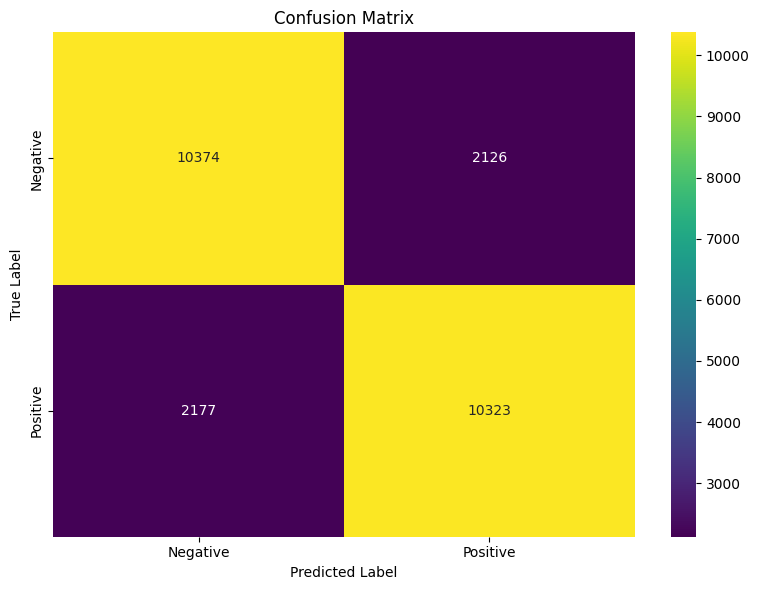

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## **Receiver Operating Characteristic (ROC) Curve**

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

roc_curve = auc(fpr, tpr)

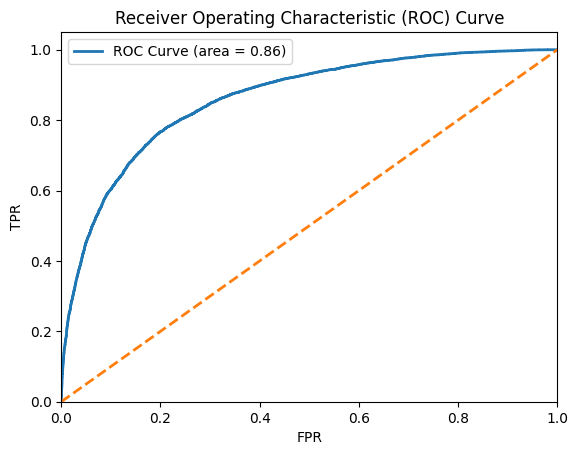

In [19]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC Curve (area = %0.2f)" % roc_curve)
plt.plot([0,1],[0,1],  lw=2, linestyle="--")
plt.xlim([0,1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# **Load the Dataset for LSTM**

***I wanted to use imdb's raw dataset to use Tokenizer***

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

# **Get Raw Texts and Labels**

In [37]:
x = []
y = []

for text, label, in dataset['train']:
    x.append(text.numpy().decode('utf-8')) # Get text as string
    y.append(label.numpy()) # Label (0: Negative, 1: Positive)

# **Create Tokenizer**

In [38]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>') # OOV = token for unknown words
tokenizer.fit_on_texts(x)

***OOV = token for unknown words***

# **Convert text to numeric**

In [40]:
x_sequences = tokenizer.texts_to_sequences(x)

# **Pad sequences**

In [ ]:
max_len = 100
x_padded = pad_sequences(x_sequences, maxlen=max_len, padding="post", truncating="post")

##  **Label Encoding**

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

##  **train-test split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

##  **Build LSTM Model**

In [76]:
def build_lstm_model():
    model = Sequential()

    model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
    model.add(LSTM(units=63, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="softmax"))
    model.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    return model

In [77]:
lstm_model = build_lstm_model()

In [78]:
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##  **EarlyStopping for LSTM**

In [79]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

In [80]:
history = lstm_model.fit(x_train, y_train, epochs=10, batch_size=64,
                   validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4880 - loss: 1.2471 - val_accuracy: 0.5620 - val_loss: 0.6920
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5279 - loss: 0.6988 - val_accuracy: 0.5975 - val_loss: 0.6544
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6885 - loss: 0.5917 - val_accuracy: 0.8180 - val_loss: 0.4333
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8731 - loss: 0.3320 - val_accuracy: 0.8110 - val_loss: 0.4397
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9178 - loss: 0.2400 - val_accuracy: 0.8165 - val_loss: 0.4653
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9522 - loss: 0.1656 - val_accuracy: 0.8200 - val_loss: 0.5311
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9653 - loss: 0.1264 - val_accuracy: 0.8125 - val_loss: 0.5649
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9774 - loss: 0.0916 - 

##  **Result of the LSTM Model**

In [81]:
loss, accuracy = lstm_model.evaluate(x_test, y_test)
print(f"Test loss: {loss}, test accuracy: {accuracy:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8245 - loss: 0.5019
Test loss: 0.5066332817077637, test accuracy: 0.822


In [ ]:
y_pred_prob_lstm = lstm_model.predict(x_test)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))

In [ ]:
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

##  **Training & Validation Loss and Accuracy**

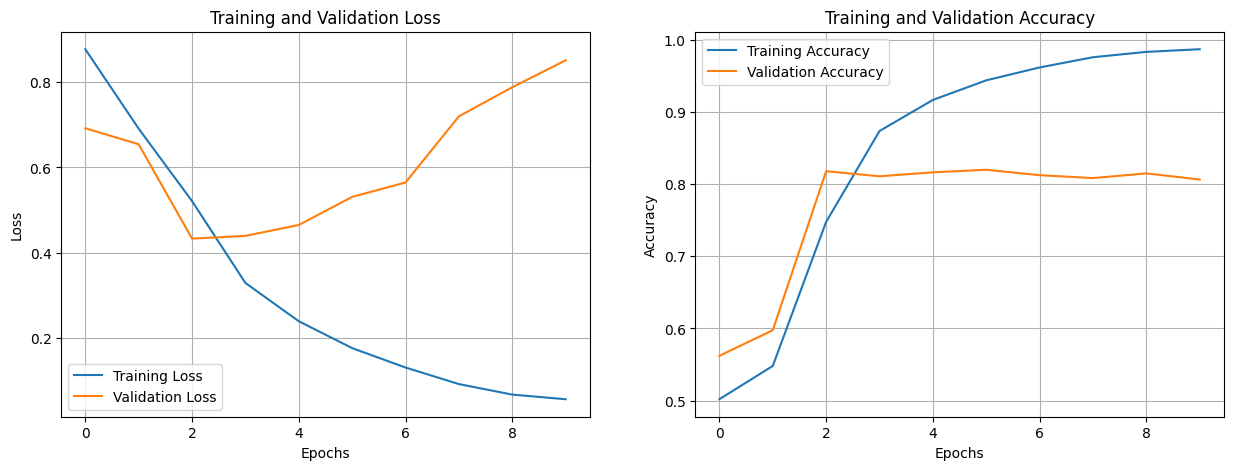

In [88]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("True")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid("True")

##  **Receiver Operating Characteristic (ROC) Curve for LSTM**

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


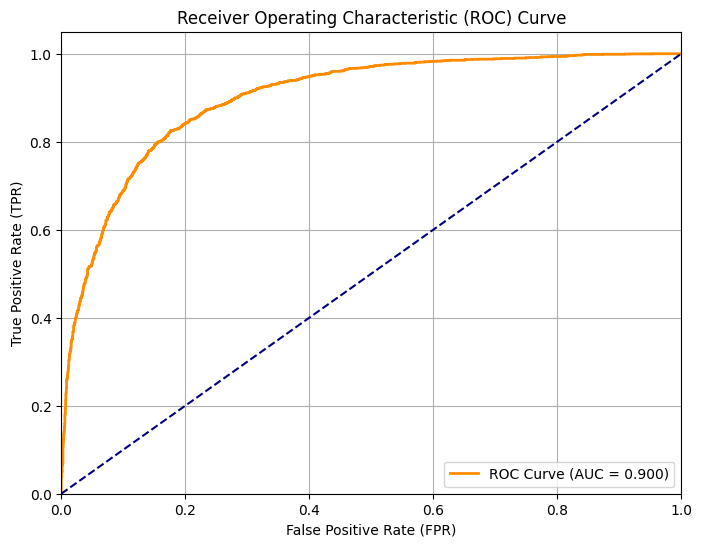

In [91]:
y_pred_probs = lstm_model.predict(x_test)

if y_pred_probs.shape[1] > 1:
    y_pred_probs = y_pred_probs[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--") 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()